In [1]:
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# nltk
import nltk
print('nltk: %s' % nltk.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# wordcloud
import wordcloud
print('wordcloud: %s' % wordcloud.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

numpy: 1.18.5
scipy: 1.4.1
matplotlib: 3.2.1
pandas: 1.0.3
nltk: 3.2.4
sklearn: 0.23.1
wordcloud: 1.7.0
keras: 2.4.3
tensorflow: 2.2.0


In [2]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import time
import matplotlib.pyplot as plt



# Packages for data preparation
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Word cloud visualization libraries
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter

import itertools

from keras.wrappers.scikit_learn import KerasClassifier

# Packages for Sequence and CNN based layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, AlphaDropout, ThresholdedReLU, Convolution1D, ZeroPadding1D, Activation, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional,BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard

In [3]:
# location of data
DATA_FILE = '../input/tweets/Tweets.csv'

# data columns for learning
TEXT_COLUMN_NAME = 'text'
LABEL_COLUMN_NAME = 'airline_sentiment'

# EMBEDDINGS FILE 
GLOVE_EMBEDDINGS_FILE = 'embeddings/glove.6B.100d.txt'
FASTTEXT_EMBEDDINGS_FILE = 'embeddings/wiki-news-300d-1M.vec'

# parameters for learning
# Parameter indicating the number of words we'll put in the dictionary
# (change it per source)
NB_WORDS = 10000
VAL_SIZE = 1000  # Size of the validation set
NB_EPOCHS = 20  # Number of epochs
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
# Maximum number of words in a sequence (see the sentence distribution)
MAX_LEN = 24
EMBEDDING_DIM = 100  # Number of dimensions of the GloVe word embeddings
FASTTEXT_EMBEDDING_DIM = 300  # Number of dimensions of the FastText word embeddings
MAX_SENT_LEN = 300  # character based length
MAX_DOC_LEN = 5  # Number of sentences in text

# labels
labels = ['negative', 'neutral', 'positive']

In [4]:
# read the file
tweets = pd.read_csv(DATA_FILE)
tweets = tweets.reindex(np.random.permutation(tweets.index))  
# only the text and labels
tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]
# get a peek of the data
tweets.head()

,text,airline_sentiment
10586,@USAirways - been on hold with reservations fo...,negative
10829,@USAirways how do I get you to stop sending me...,negative
10293,@USAirways is the worst. Why on earth would @A...,negative
7428,@JetBlue Thank you for the reply. Would've app...,negative
4513,@SouthwestAir way to fuck up and lose @c_istud...,negative


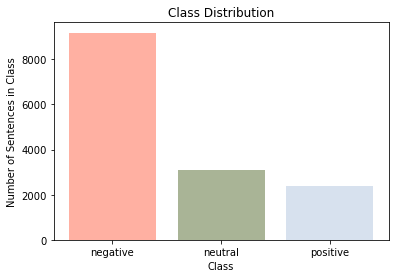

In [5]:
text = tweets[TEXT_COLUMN_NAME]
sentiments = tweets[LABEL_COLUMN_NAME]

# unique labels
sentiments.unique()
# group by
grouped = tweets.groupby([LABEL_COLUMN_NAME])[TEXT_COLUMN_NAME].count()
plt.bar(
    labels,
    grouped.values,
    align='center',
    color=[
        'tomato',
        'darkolivegreen',
        'lightsteelblue'],
    alpha=0.5)
plt.ylabel('Number of Sentences in Class')
plt.xlabel('Class')
plt.title('Class Distribution')

plt.show()

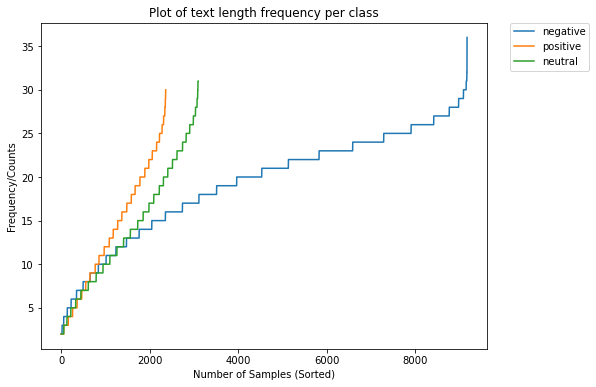

In [6]:
# Set of unique label
lbl_set = list(set(sentiments))


def length_counter(all_label, all_text, class_name):

    class_txt = []

    # Seperate all lines for a class
    for lbl, txt in zip(all_label, all_text):
        if lbl == class_name:
            class_txt.append(txt)

     # Count words per line of that class
    line_word_count = []
    for k in range(len(class_txt)):
        line_words = class_txt[k].lower().split()
        line_word_count.append(len(line_words))

    return np.sort(line_word_count)


plt.figure(figsize=[8, 6])
for lbl in lbl_set:
    count = length_counter(sentiments, text, lbl)
    plt.plot(np.arange(1, len(count) + 1, 1), count, label=lbl)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Plot of text length frequency per class")
plt.xlabel("Number of Samples (Sorted)")
plt.ylabel("Frequency/Counts")
plt.show()

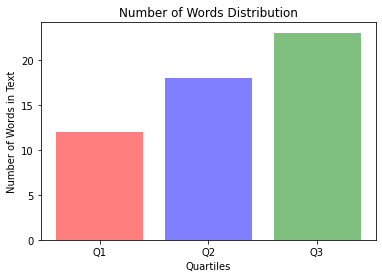

In [7]:
# ADD WORDS DERIVED COLUMN
NUMBER_OF_WORDS_COLUMN = TEXT_COLUMN_NAME + 'NB_WORDS_COLUM'
tweets[NUMBER_OF_WORDS_COLUMN] = tweets[TEXT_COLUMN_NAME].str.split().apply(len)
data = tweets[NUMBER_OF_WORDS_COLUMN].describe()

quartiles = ['Q1', 'Q2', 'Q3']
top = [data['25%'], data['50%'], data['75%']]
plt.bar(
    quartiles,
    top,
    align='center',
    color=[
        'red',
        'blue',
        'green'],
    alpha=0.5)
plt.ylabel('Number of Words in Text')
plt.xlabel('Quartiles')
plt.title('Number of Words Distribution')

plt.show()

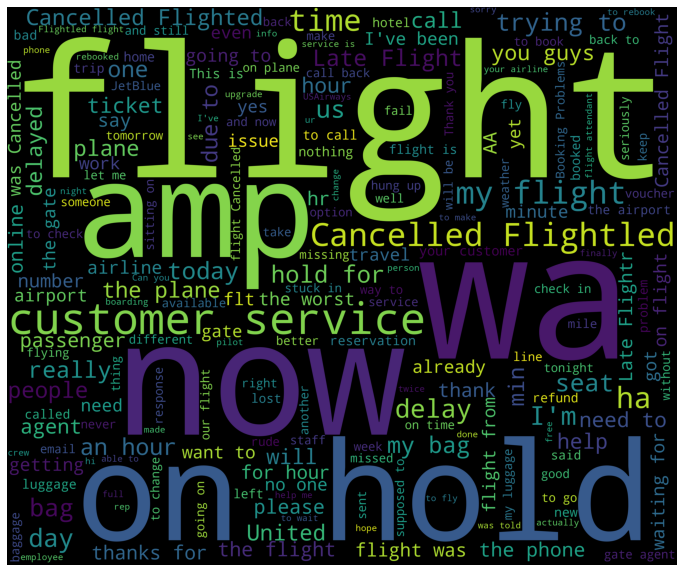

In [8]:
negative_df = tweets[tweets[LABEL_COLUMN_NAME] == 'negative']
words = ' '.join(negative_df[TEXT_COLUMN_NAME])
negative_cleaned_words = " ".join([word for word in words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(negative_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

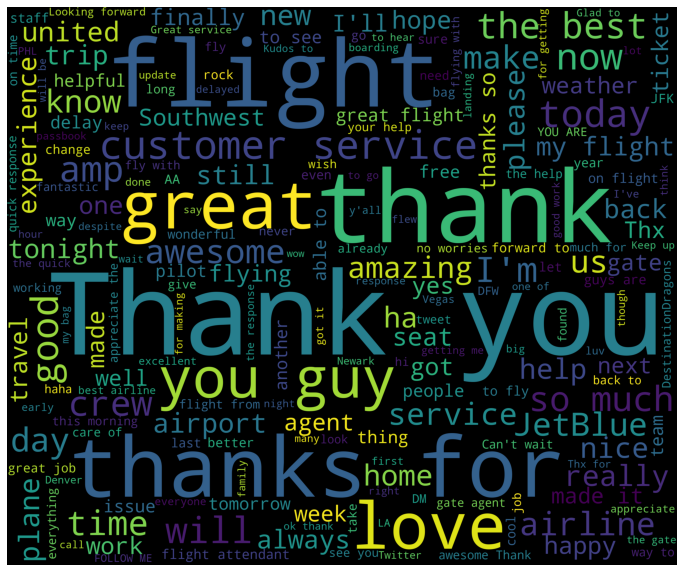

In [9]:
positive_df = tweets[tweets[LABEL_COLUMN_NAME] == 'positive']
all_positive_words = ' '.join(positive_df[TEXT_COLUMN_NAME])
positive_cleaned_words = " ".join([word for word in all_positive_words.split()
                                   if 'http' not in word
                                   and not word.startswith('@')
                                   and word != 'RT'
                                   ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                      ).generate(positive_cleaned_words)
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
# remove stop words with exceptions
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept
    white_list = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (
        word not in stopwords_list or word in white_list) and len(word) > 1]
    return " ".join(clean_words)
# remove mentions


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)


tweets = tweets[[TEXT_COLUMN_NAME, LABEL_COLUMN_NAME]]
tweets[TEXT_COLUMN_NAME] = tweets[TEXT_COLUMN_NAME].apply(
    remove_stopwords).apply(remove_mentions)
tweets.head()

,text,airline_sentiment
10586,hold reservations 30 min already! #worstairline,negative
10829,get stop sending emails ex boyfriends account...,negative
10293,worst. Why earth would merge them? flying ei...,negative
7428,Thank reply. Would've appreciated communicati...,negative
4513,way fuck lose bags. My husband no warm cloth...,negative


In [11]:
X_train_entire, X_test, y_train_entire, y_test = train_test_split(
    tweets[TEXT_COLUMN_NAME], tweets[LABEL_COLUMN_NAME], test_size=0.15, random_state=37)
print('# Train data samples:', X_train_entire.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train_entire.shape[0] == y_train_entire.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 12444
# Test data samples: 2196


In [12]:
# tokenization with max words defined and filters
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train_entire)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))

Fitted tokenizer on 12444 documents
10000 words in dictionary


In [13]:
# understand the sequence distribution for max length 
seq_lengths = X_train_entire.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    12444.000000
mean        10.918756
std          4.209674
min          1.000000
25%          8.000000
50%         11.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64